# Factor Analysis
During the previous steps many columns were removed, but there are still hundreds of columns in the data set. We could use PCA for dimensional reduction, but factor analysis provides better explainability while reducing the dimensions. We could associate the factors to the features that are representing most strongly.

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from ab_test import *

In [ ]:
def plot_attribute(attribute_name, kde=True):
    """
    The plot_attribute method plots the distributions of an attribute in exposed and control data
    :param attribute_name: name of the attribute (column) to plot
    :param kde: True or False to plot kde
    :return: Ruturns no object. Inline plot only
    """
    control_data = df_control
    exposed_data = df_exposed

    # Create new columns to hold whether data is exposed or control
    control_data_copy = control_data.copy().reset_index(drop=True)
    control_data_copy['group'] = 'control'

    exposed_data_copy = exposed_data.copy().reset_index(drop=True)
    exposed_data_copy['group'] = 'exposed'

    # Concat the copies of control and exposed data
    combined_data = pd.concat([control_data_copy, exposed_data_copy]).reset_index(drop=True)
    sns.histplot(data=combined_data, x=attribute_name, hue='group', kde=kde)
    # # Plot the distribution of the attribute in the control group
    # sns.histplot(control_data[attribute_name], label='Control', kde=kde)
    #
    # # Plot the distribution of the attribute in the exposed group
    # sns.histplot(exposed_data[attribute_name], label='Exposed', kde=kde, \
    #              color='orange', alpha=0.4)

    plt.show()
    
def ks_test(attribute_name, df_control, df_exposed):
    from scipy.stats import ks_2samp
    control = df_control[attribute_name]
    treatment = df_exposed[attribute_name]
    stat, p_val = ks_2samp(control, treatment)
    print('p value = ', p_val)
    if p_val < 0.025:
        print("Reject null hypothesis, the two samples do not come from the same distribution.")
    else:
        print("Fail to reject null hypothesis, the two samples come from the same distribution.")

def anderson_test(attribute_name, df_control, df_exposed):
    from scipy.stats import anderson_ksamp
    control = df_control[attribute_name]
    treatment = df_exposed[attribute_name]
    result = anderson_ksamp([control, treatment])
    print(result)
    if result.critical_values[3] < result.statistic:
        print("Reject null hypothesis, the two samples do not come from the same distribution.")
    else:
        print("Fail to reject null hypothesis, the two samples come from the same distribution.")

In [4]:
# Read the merged data set that is created at the previous step: in this notebook Clustering.ipynb
df = pd.read_csv('Merged_Control_Treatment.csv')

# Multicollinearity
Factor analysis make some assumptions about the data. One of them is the data should not have strong multicollinearity. Therefore I will remove one of the members of the highly correlated pairs.

In [12]:
# Step 1. Call the variable corr_matrix
corr_matrix = df.corr().abs()

# Step 2. Uncomment the following code to get the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Step 3. This code iterates through our columns and gets the index of any that have a correlation > 0.95
# Call the variable to_drop, get the columns of our 'upper' variable, make sure the threshold is 0.95.
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
# Let's see those features!
print('Features selected to drop include:',to_drop)

Features selected to drop include: ['msa', 'avg_yrs_education', 'avg_family_size', 'avg_hh_size', 'avg_hh_size_owner_occupied', 'avg_hh_size_renter_occupied', 'avg_num_vehicles', 'median_age', 'median_rooms_in_bldg', 'pct_english_speaking', 'pct_family_hh', 'pct_in_mgmt', 'pct_married_by_population', 'pct_owner_occupied', 'pct_in_sales', 'pct_school_enrolled', 'pct_sfdu', 'bookbuyer', 'collectors', 'contribute_political_conservative', 'hobby_cooking_gourmet', 'hobby_crafts', 'hobby_sewing', 'hobby_video_games', 'hobbyists', 'mail_buyer', 'movie', 'music', 'online_education', 'sports', 'toys', 'prpty080', 'prpty082', 'prpty088', 'Treatment']


In [ ]:
# remove the 'Treatment' from the to_drop list and drop all the other columns from the data
to_drop.remove('Treatment')
to_drop

In [16]:
# Removing these columns
df = df.drop(columns=to_drop)
#Save this to use in modeling part
df.to_csv('preprocessed.csv')

## Adequecy check
It is important to verify if the data collected is appropriate for factor analysis. To do this, we use the Bartlett Sphericity Test, which assesses the connection between the variables being analyzed. If the test yields a significant result, which means a distinction between the correlation matrix and identity matrix, it suggests that factor analysis is appropriate. In this scenario, the test applied to our data yielded a p-value of 0.0, which indicates that the data is suitable for factor analysis.

In [ ]:
#CHECK ADEQUACY
#Bartlett
#p-value should be 0 (statistically sig.)
chi_square_value,p_value=calculate_bartlett_sphericity(df.query('Treatment ==1'))
print(chi_square_value, p_value)


## Number of Factors

In [ ]:
#EXPLORATORY FACTOR ANALYSIS
fa = FactorAnalyzer(10, rotation=None)
fa.fit(df)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
               use_smc=True)

#GET EIGENVALUES
fa.get_eigenvalues()


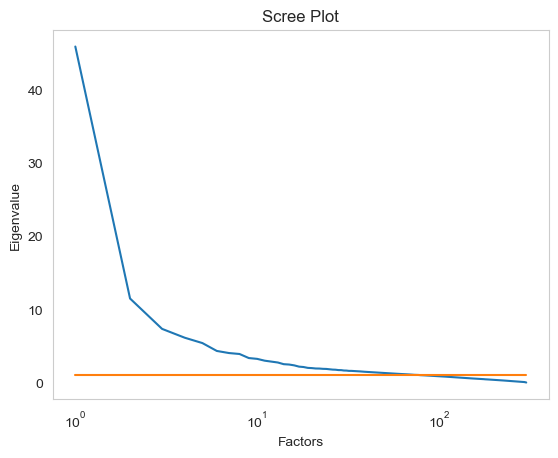

In [51]:
# SCREEPLOT
ev, _ = fa.get_eigenvalues()
# plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),np.ones(len(df.columns)))
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.xscale('log')
plt.grid()
plt.show()

 Scree plot sugest about Near 100 the eigen values dro below 1. An eigenvalue of 1.0 corresponds to the amount of variance that might be attributed to a single independent variable; a factor that captures less variance than such an item may be considered relatively uninteresting.
 To see the exact number factors let's check the Eigen values in a series

In [61]:
pd.DataFrame(pd.Series(ev), columns=['eigen_value']).\
    query('eigen_value > 1').sort_values(by='eigen_value').head(1)

,eigen_value
81,1.004289


In [66]:
pd.DataFrame(pd.Series(ev))

,0
0,45.947272
1,11.499679
2,7.348888
3,6.138082
4,5.407957
...,...
297,0.057975
298,0.054973
299,0.051353
300,0.033969


Here, we can see 81-factors eigenvalues are greater than one. It means we need to choose only 81 factors (or unobserved variables) for the best result. However, even though this will reduce the dimensions significanly it will still be difficult for intrpretation. Hence I will cut the factors at eigen value greater than. This will give us 18 factors. Now let's dod the factor analysis with 18 factors

In [71]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [103]:
fa = FactorAnalyzer(n_factors=18, rotation='oblimin')
fa.fit(df.drop('Treatment', axis=1))
fa_loadings_df = pd.DataFrame(fa.loadings_,
                              index=df.drop('Treatment', axis=1).columns)
fa_loadings_df.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
income,0.01,-0.03,-0.02,0.05,-0.02,-0.06,-0.12,0.07,0.45,-0.07,-0.10,-0.02,-0.00,-0.02,0.10,0.22,0.09,0.03
credit_card,-0.04,-0.03,-0.01,-0.04,-0.04,-0.04,0.02,0.05,0.00,0.04,-0.01,0.63,0.09,0.02,0.01,-0.04,0.09,0.02
credit_cards_regular_visa_or_mastercard,-0.14,-0.01,-0.01,-0.05,0.03,-0.06,-0.03,0.06,-0.01,0.05,-0.00,0.65,0.09,0.07,-0.02,-0.00,0.13,-0.01
gdiscindex,0.16,-0.03,-0.04,-0.03,0.08,-0.08,-0.05,0.48,0.24,0.01,-0.02,0.08,0.04,0.09,0.11,0.14,0.05,0.05
gen_in_household,0.01,0.03,-0.01,0.06,-0.03,0.07,0.15,0.57,0.02,-0.06,0.05,-0.16,0.10,-0.07,-0.01,-0.04,0.03,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
net_worth_G,-0.41,0.05,-0.01,-0.06,-0.01,-0.04,0.12,0.08,0.09,0.15,0.05,0.07,0.05,-0.12,-0.07,0.05,0.04,-0.05
net_worth_H,0.14,0.11,-0.04,-0.04,-0.03,-0.03,-0.04,0.06,0.14,0.05,-0.05,-0.01,-0.07,0.05,0.03,0.07,0.09,0.18
net_worth_I,0.05,0.01,-0.06,0.09,0.05,-0.03,-0.10,0.13,0.14,-0.10,-0.08,-0.09,-0.08,0.01,0.11,0.18,0.10,0.02
urbanicity_S,0.05,0.07,-0.04,0.10,-0.13,-0.00,-0.03,0.02,0.10,0.06,-0.01,-0.03,0.06,-0.01,-0.37,-0.01,0.05,0.07


In [104]:
# Get variance of each factors
pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
SS Loadings,10.346521,8.800710,8.056219,6.708715,6.041374,4.162416,4.148532,3.808367,3.646177,3.615531,3.606347,3.384836,2.973825,2.830582,2.426583,2.311153,2.264989,2.251157
Proportion Var,0.034488,0.029336,0.026854,0.022362,0.020138,0.013875,0.013828,0.012695,0.012154,0.012052,0.012021,0.011283,0.009913,0.009435,0.008089,0.007704,0.007550,0.007504
Cumulative Var,0.034488,0.063824,0.090678,0.113041,0.133178,0.147053,0.160882,0.173576,0.185730,0.197782,0.209803,0.221086,0.230999,0.240434,0.248522,0.256226,0.263776,0.271280


In [106]:
pd.DataFrame(fa.get_communalities(),index=df.drop('Treatment', axis=1).columns,columns=['Communalities'])

,Communalities
income,0.308555
credit_card,0.428334
credit_cards_regular_visa_or_mastercard,0.489843
gdiscindex,0.387070
gen_in_household,0.407286
...,...
net_worth_G,0.265566
net_worth_H,0.120939
net_worth_I,0.149695
urbanicity_S,0.204106


In [108]:
# Getting the Factors
# Remove the treatment column then add it back after factors calculated
factor_analysis = FactorAnalysis(n_components=18)
factor_analysis.fit(df.drop('Treatment', axis=1))
df_factors = pd.DataFrame(factor_analysis.transform(df.drop('Treatment', axis=1)))
df_factors['Treatment'] = df['Treatment']
df_factors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,Treatment
0,0.256828,-0.160843,-0.192684,-0.261075,0.291249,-0.259505,0.236221,0.400615,-0.343955,0.221970,-1.084176,-0.043812,0.613693,0.172940,-0.405591,0.367848,0.441929,0.550183,1
1,1.773161,-0.524460,-0.126474,-0.249418,1.079941,-0.472238,0.773715,-0.035251,-0.426968,-0.018592,-0.518783,-1.510186,0.356453,0.269413,0.861753,-0.984334,1.096967,1.295111,1
2,-0.894710,-0.420165,0.382668,-0.166250,0.765618,-0.261003,-0.286100,0.994939,0.225782,1.017746,-0.246086,-0.912415,-1.090124,0.242217,-0.869993,0.209065,0.274058,0.281124,1
3,-0.743775,-0.614812,1.089159,-0.418640,1.592881,-0.369974,-0.224789,-1.538421,-1.091239,0.989551,-0.763900,-1.910870,1.679453,4.037932,-1.256119,0.570455,0.330174,0.033115,1
4,0.362437,0.771882,-0.146236,0.227754,-1.819962,-0.268943,0.499653,0.767845,-0.398163,0.417129,-0.644898,-0.155598,-0.261174,0.162776,0.137630,0.528684,-0.750405,-0.014901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.340199,-0.441610,-0.707313,-0.124069,0.700417,-0.455803,-0.891004,0.681181,-0.544231,-0.521689,0.164624,0.082615,-0.238327,-0.110257,-0.212482,-0.213958,-2.194838,-0.178157,0
1996,0.914849,0.105914,-0.680884,0.152809,0.084982,-0.448463,-0.874861,0.304969,-0.571201,-0.605862,0.299926,0.193794,-0.235881,-0.069488,-0.194602,-0.192612,1.327085,0.535287,0
1997,0.299923,-0.359091,0.182904,-0.932659,0.064181,-0.406598,-1.032290,-0.017721,0.687644,-0.336743,0.158423,0.045075,-0.010005,-0.118107,-0.223336,-0.188312,2.874519,0.563319,0
1998,1.811907,-0.107140,-0.218918,-0.251986,-0.121286,-0.482803,-0.836560,0.296415,-0.317263,-0.404979,0.035725,-0.094519,-0.204882,-0.052691,-0.322596,-0.170304,0.768940,0.676400,0


## Comparing the Treatment and Control Group

In [109]:
df_control = df_factors.query('Treatment == 0')
df_exposed = df_factors.query('Treatment == 1')

In [ ]:
# comparison = ControlExposedComparison(df_control, df_exposed)

# top_attr_df, all_attr_df = comparison.compare_attributes()

In [ ]:
import seaborn as sns
for attribute in df_factors.columns:
    comparison.plot_attribute(attribute, kde=True)

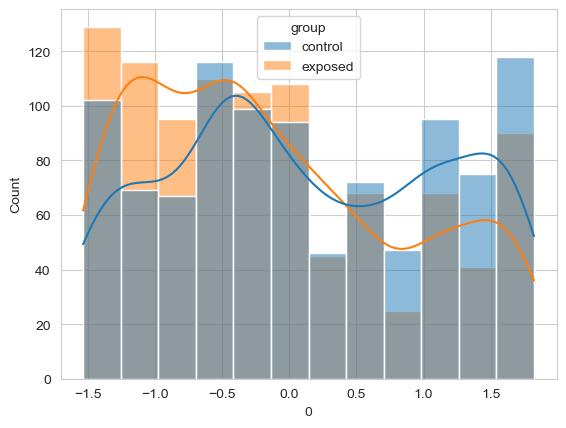

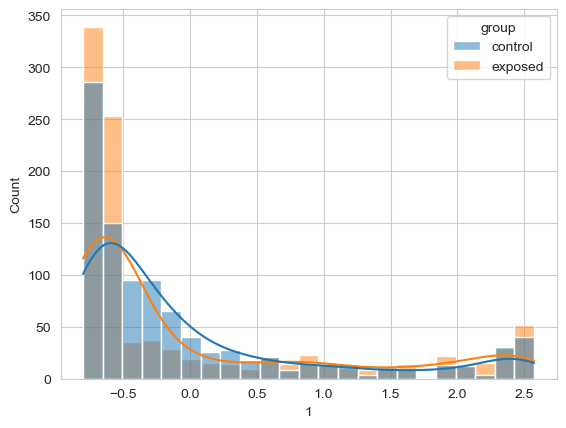

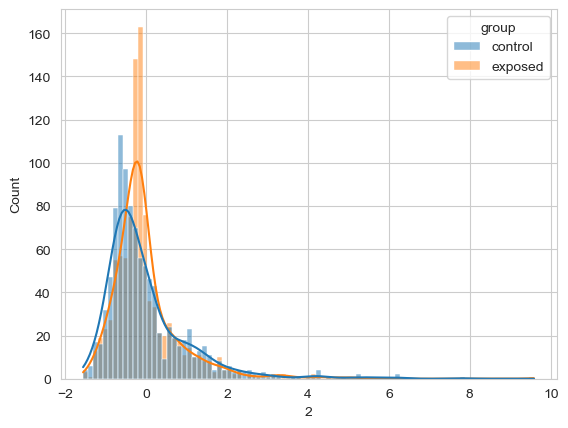

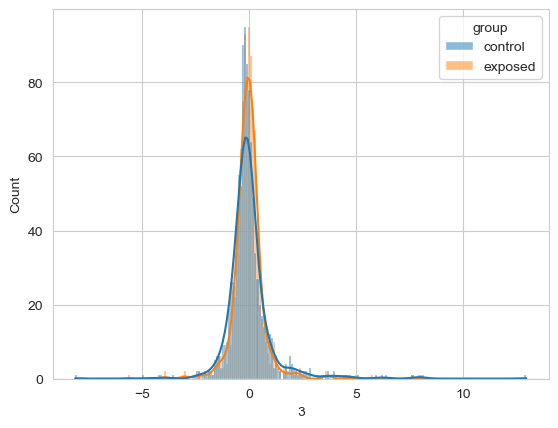

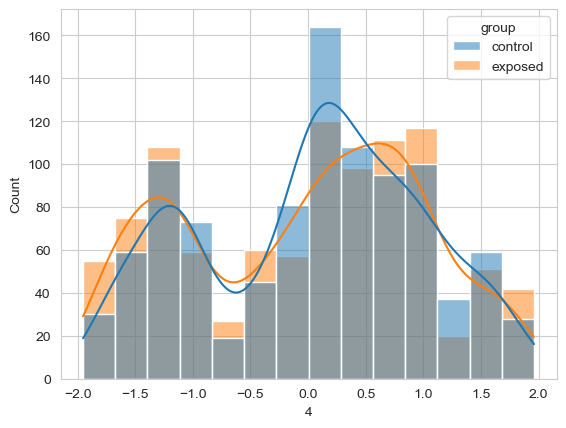

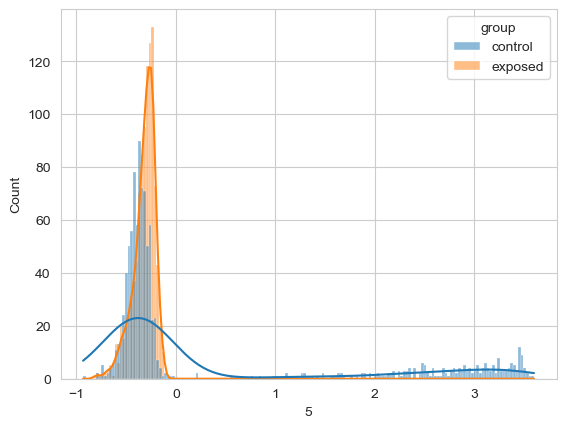

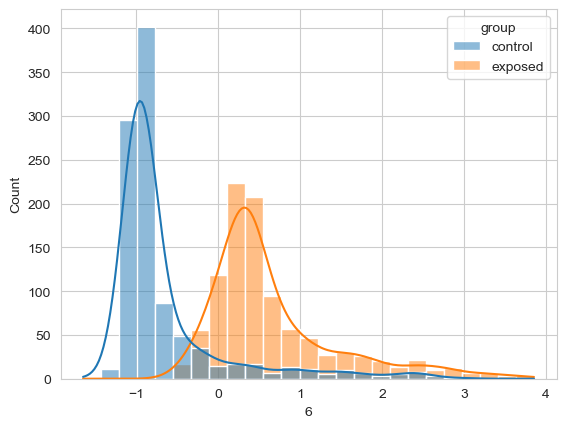

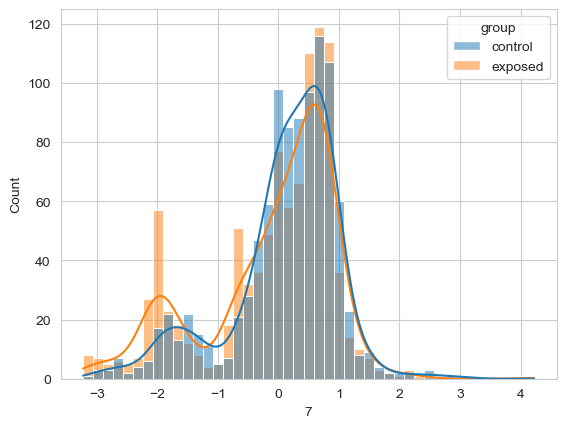

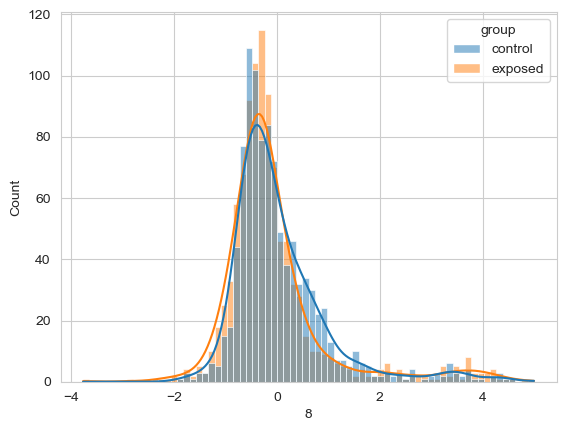

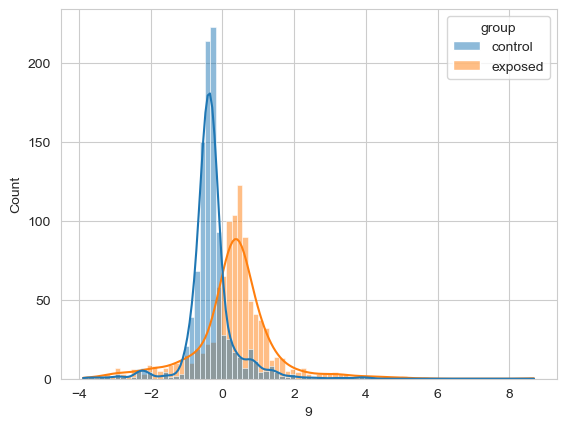

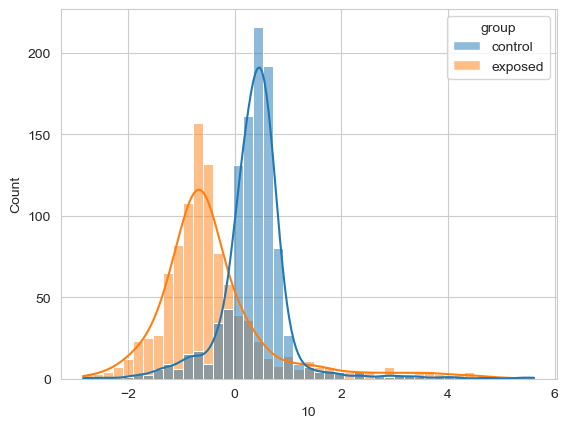

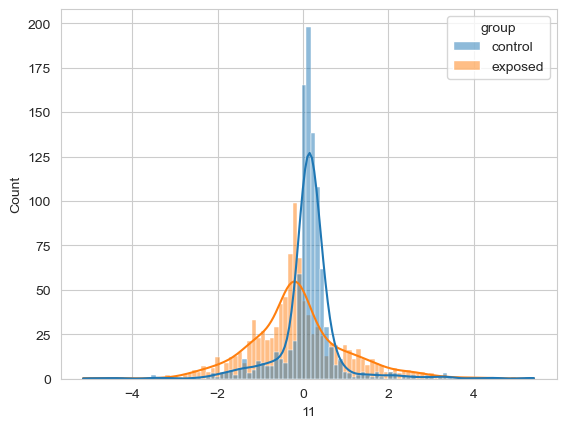

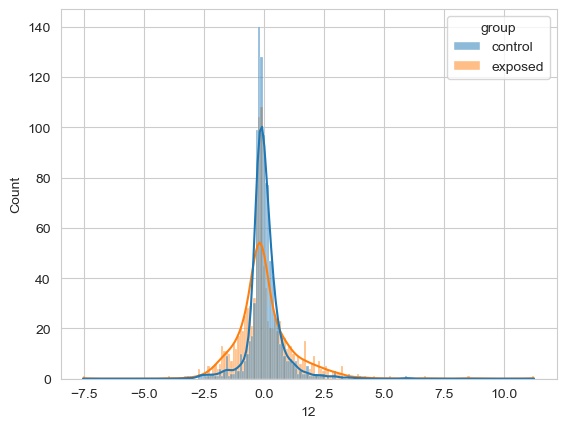

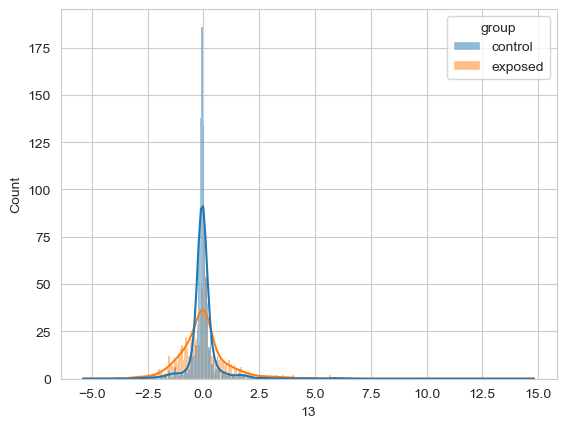

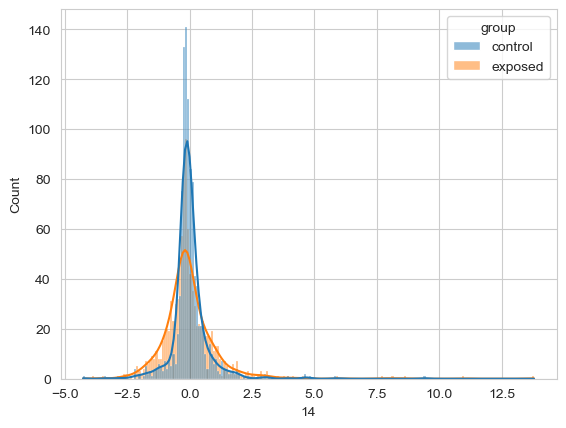

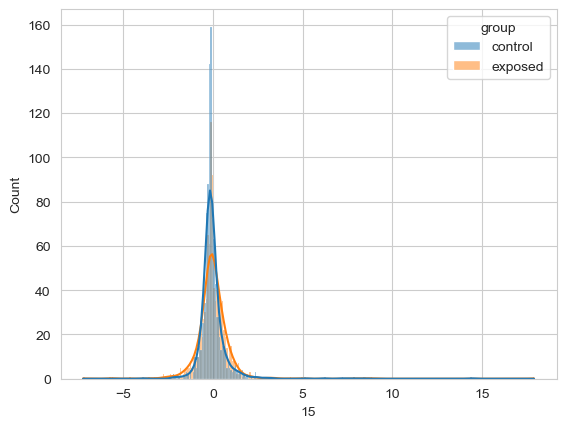

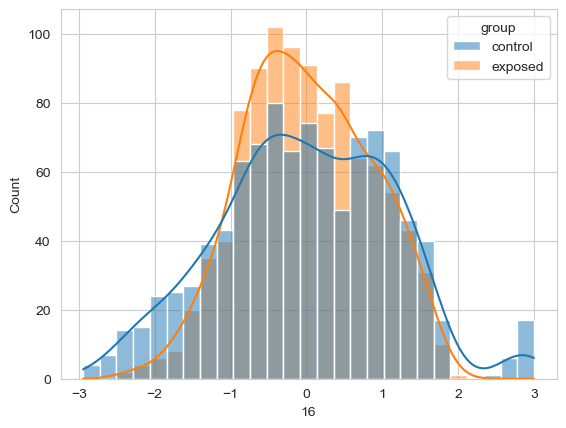

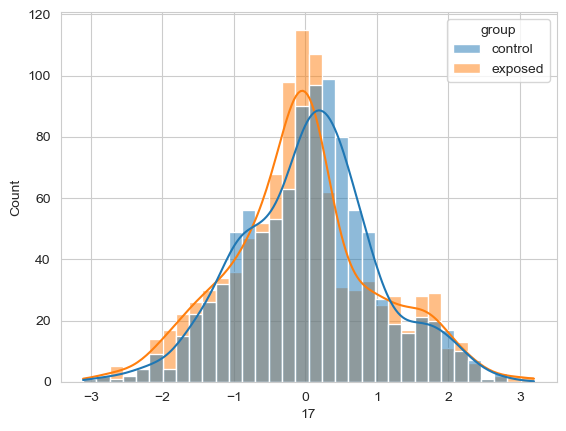

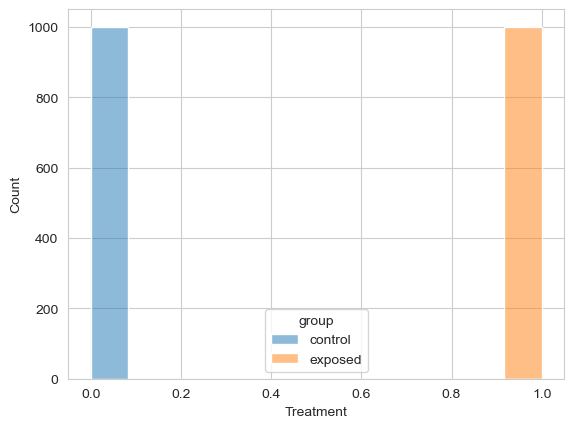

In [127]:
for attribute in df_factors.columns:
    plot_attribute(attribute, kde=True)

Some factors' distributions look different under different group. Let's make an objective test to see which factors are different using Kolmogorov-Smirnov Test which is sensitive to the tails, and Anderson-Darling test which is not.

In [177]:
# KS-Test
for attribute in df_factors:
    print('The Factor:',attribute)
    ks_test(attribute, df_control, df_exposed)

The Factor: 0
p value =  1.4776675436423948e-07
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 1
p value =  1.907452160715277e-11
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 2
p value =  2.4846719977672545e-13
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 3
p value =  0.004543821879051605
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 4
p value =  0.07761108123267829
Fail to reject null hypothesis, the two samples come from the same distribution.
The Factor: 5
p value =  7.8580359170637845e-25
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 6
p value =  0.0
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 7
p value =  2.214758736930358e-06
Reject null hypothesis, the two samples do not come from the same distribution.
T

In [178]:
# AD-Test
for attribute in df_factors:
    print('The Factor:',attribute)
    anderson_test(attribute, df_control, df_exposed)

The Factor: 0
Anderson_ksampResult(statistic=20.83879793811983, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 1
Anderson_ksampResult(statistic=11.662807723368386, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 2
Anderson_ksampResult(statistic=21.00507273866118, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 3
Anderson_ksampResult(statistic=8.663540188943934, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Reject null hypothesis, the two samples do not come from the same distribution.
The Factor: 4
Anderson_

Test were conducted at $\alpha = 0.025$ significance level
* According to Anderson-Darling test none of the factors come from the same distribution
* Both tests fail to reject the null hypothesis ( both coming from the same distribution) for Factor 4 .
* From the plots it looks like the difference in factors 6, 9 and 10 is more signifant. So let's see what these factors are

In [161]:
fa_loadings_df.round(2)[6].apply(abs).sort_values(ascending=False).where(fa_loadings_df[6] > 0.2).dropna().index

Index(['avg_commute_drive_time', 'pct_in_service', 'pct_non_family_hh',
       'pct_in_prod_trans', 'pct_in_construction_maint', 'pct_renter_occupied',
       'pct_hispanic', 'pct_white'],
      dtype='object')

In [160]:
fa_loadings_df.round(2)[9].apply(abs).sort_values(ascending=False).where(fa_loadings_df[9] > 0.2).dropna().index

Index(['family', 'presence_premium_card', 'femalemerchbuyer', 'hightechleader',
       'presenceofgoldorplatinumcreditcard', 'mo_children_s_products',
       'mo_cosmetics', 'collect_specialfoodsbuyer', 'luxury_life',
       'retail_card', 'sporting_life', 'internet_buyer', 'mo_jewelry',
       'travel_business', 'cc_regular_american_express',
       'cc_premium_visa_or_mastercard', 'cc_premium_store_or_retail',
       'bank_card', 'travel_card', 'health_beauty', 'collector_antiques',
       'food', 'children_interests', 'music_player', 'great_outdoors'],
      dtype='object')

In [162]:
fa_loadings_df.round(2)[10].apply(abs).sort_values(ascending=False).where(fa_loadings_df[10] > 0.2).dropna().index

Index(['cvh159', 'combineseg01b', 'cvh128', 'cha08', 'chh20', 'cvh139',
       'combineseg07b', 'combineseg06b', 'cvh169', 'cha04', 'chh08', 'cvh149',
       'cvh113', 'cvh52', 'chr04', 'combineseg03a', 'ihs70'],
      dtype='object')

* Factor 6 has high factor loadings for `avg_commute_drive_time`, `pct_in_service`, `pct_non_family_hh`, `pct_in_prod_trans`, `pct_in_construction_maint`, `pct_renter_occupied`, `pct_hispanic`, `pct_white`, `pct_in_prod_trans`. This factor seems like condensed the percentage related features mostly
* Factor 9 has high factor loadings for  `family`, `presence_premium_card`, `femalemerchbuyer`, `hightechleader`, `presenceofgoldorplatinumcreditcard`, `mo_children_s_products`, `mo_cosmetics`, `collect_specialfoodsbuyer`, `luxury_life`, `retail_card`, `sporting_life`, `internet_buyer`, `mo_jewelry`, `travel_business`, `cc_regular_american_express`, `cc_premium_visa_or_mastercard`,`cc_premium_store_or_retail`, `bank_card`, `travel_card`, `health_beauty`, `collector_antiques`, `food`, `children_interests`, `music_player`, `great_outdoors`. This factor more related to weatlthy consumers as it collects shoping and luxury type features.
* Factor 10 has high factor loadings for `cvh159`, `combineseg01b`, `cvh128`, `cha08`, `chh20`, `cvh139`, `combineseg07b`, `combineseg06b`, `cvh169`, `cha04`, `chh08`, `cvh149`, `cvh113`, `cvh52`, `chr04`, `combineseg03a`, `ihs70`. This factor is related to consumers financial situation especialy the ones related to loan applications

In [ ]:
fa_loadings_df.round(2)[5].apply(abs).sort_values(ascending=False).where(fa_loadings_df[5] > 0.2).dropna().index

In [151]:
fa_loadings_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
income,0.009142,-0.028587,-0.020978,0.047661,-0.019483,-0.062232,-0.121501,0.074941,0.447265,-0.070220,-0.095578,-0.017777,-0.003888,-0.023494,0.097153,0.216512,0.090485,0.028506
credit_card,-0.044678,-0.025761,-0.014064,-0.041475,-0.035773,-0.037694,0.018765,0.053444,0.002880,0.043533,-0.005966,0.630829,0.091082,0.022480,0.005714,-0.035957,0.085869,0.021512
credit_cards_regular_visa_or_mastercard,-0.142659,-0.008452,-0.007492,-0.049004,0.031179,-0.055551,-0.030510,0.062586,-0.005425,0.049758,-0.001675,0.653103,0.088918,0.067522,-0.015608,-0.001904,0.127160,-0.011056
gdiscindex,0.159960,-0.030986,-0.038794,-0.026365,0.076904,-0.084773,-0.048039,0.480932,0.237810,0.011643,-0.016965,0.083462,0.039795,0.092928,0.114834,0.138401,0.052833,0.048206
gen_in_household,0.014066,0.031844,-0.011173,0.062651,-0.029411,0.068253,0.147904,0.568334,0.020795,-0.061879,0.049625,-0.162071,0.103534,-0.070746,-0.006853,-0.039120,0.028417,-0.022847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
net_worth_G,-0.414044,0.051305,-0.009471,-0.059241,-0.007603,-0.035930,0.118807,0.081412,0.085444,0.153764,0.052233,0.067533,0.050350,-0.117792,-0.072229,0.048117,0.037319,-0.047348
net_worth_H,0.137511,0.108771,-0.039016,-0.044393,-0.032916,-0.027428,-0.036168,0.058497,0.139105,0.051271,-0.051771,-0.007119,-0.074079,0.046598,0.027169,0.071211,0.093698,0.182159
net_worth_I,0.054769,0.005497,-0.055611,0.093140,0.047537,-0.026505,-0.097949,0.126552,0.139404,-0.102115,-0.083348,-0.090211,-0.082139,0.006955,0.111974,0.177516,0.099635,0.024641
urbanicity_S,0.054709,0.071307,-0.040639,0.099540,-0.133191,-0.002183,-0.025521,0.023002,0.099046,0.055318,-0.010285,-0.031165,0.059716,-0.005442,-0.374891,-0.006655,0.047155,0.072039


Now let's see the similar factors
Based on KS & AD statistics and visual inspection of distribution plots the following Factors have similar distribution with almost the same mean:

* Factor 3
* Factor 4
* factor 8
* Factor 16

In [185]:
print('Factor 3')
fa_loadings_df.round(2)[3].apply(abs).sort_values(ascending=False).where(fa_loadings_df[3] > 0.3).dropna().index

Factor 3


Index(['football', 'basketball', 'baseball', 'tv_sports',
       'contribute_childrens', 'reading_bible_or_devotional',
       'contribute_religious', 'walking', 'diet_weight_loss', 'hockey',
       'general_info_grandchildren_le_12_yrs', 'travel_cruises',
       'contribute_health', 'contribute_animal',
       'cc_premium_visa_or_mastercard', 'music_player', 'contribute_veterans',
       'mo_books_or_mag', 'nascar'],
      dtype='object')

In [186]:
print('Factor 4')
fa_loadings_df.round(2)[4].apply(abs).sort_values(ascending=False).where(fa_loadings_df[4] > 0.3).dropna().index

Factor 4


Index(['hobby_woodworking', 'auto_work', 'collector_stamps',
       'hobby_photography', 'camping_or_hiking', 'hobby_board_games',
       'collector_coins', 'hobby_computer_games', 'fishing', 'hunting',
       'science_space', 'cars', 'boating_or_sailing',
       'hobby_knitting_or_needlework', 'sweepstakes_contest', 'career_minded',
       'reading_news_finance', 'current_affairs_politics', 'great_outdoors',
       'casino_gambling', 'hobby_self_improvement_courses', 'truck_owner',
       'pets_own_at_least_one_cat'],
      dtype='object')

In [187]:
print('Factor 8')
fa_loadings_df.round(2)[8].apply(abs).sort_values(ascending=False).where(fa_loadings_df[8] > 0.3).dropna().index

Factor 8


Index(['cvh205', 'combineseg04b', 'income', 'chm04', 'cvh06', 'chm14', 'ihs74',
       'median_housing_unit_value', 'wealthrating', 'cvh193', 'cvh58',
       'prpty144'],
      dtype='object')

In [191]:
print('Factor 16')
fa_loadings_df.round(2)[16].apply(abs).sort_values(ascending=False).where(fa_loadings_df[16] > 0.2).dropna().index

Factor 16


Index(['prptycom106', 'prpty143', 'prpty144'], dtype='object')

* Factor 3: This factor combines the attributes related to life style of consumers.
* Factor 4 combines attribute related to consumers interests, hobbies.
* Factor 8: combines in general the attributes related to wealthy consumers with high spending and high mortgage loan.
* Factor 16: This factor combines in general the attributes related to home value to mortgage ratio of the consumers

In [193]:
# save the data with reduced dimension to use it in the next section: Modelling.
df_factors.to_csv('data/factors.csv')